### Contributor:
Niklas Kaspareit (niklas.kaspareit@uni-potsdam.de) 

## Sheet 04 Exercise 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import markers
import pandas as pd

In [2]:
# originally... our code from the bayesian exercise
def KFilter(mu0,var0):
    global N, Y
    
    means, var = [mu0], [var0]
    zBarA, zVarA = [mu0], [var0]
    
    for i in np.arange(1, N):
        zBarF = 0.99 * means[i-1] # We do not need to add anything more as Epsilon ~ N(0, 0.3) so mean = 0
        zVarF = 0.99**2 * var[i-1] + 0.3 # Here we add the variance of Epsilon ~ N(0, 0.3)
        
        K = zVarF / (0.5 + zVarF)
        
        means.append(zBarF - K * (zBarF - Y[i-1]))
        var.append(zVarF - K * zVarF)
    
    return means, var

In [3]:
# load data
f_data = open('data.txt', 'r')
data = f_data.read().split()
data = list(map(float, data))
f_ref = open('reference_signal.txt', 'r')
ref = f_ref.read().split()
ref = list(map(float, ref))

5001


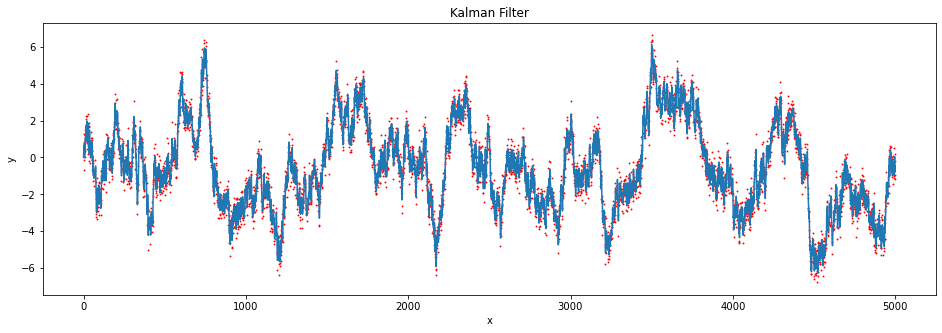

In [4]:
# init model
Y = data
N = len(data) + 1


meansKF,varsKF=KFilter(0, 0.5) # we know this from z_o ~ N(0, 0.5)
print(len(meansKF))
plt.figure(figsize=(16,5))
plt.plot(meansKF)
plt.scatter(list(range(len(data))), data, s=0.8, c='red')
plt.title('Kalman Filter')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

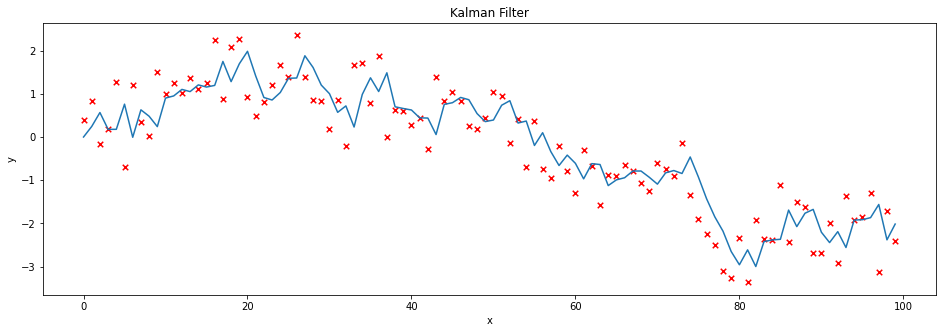

In [5]:
plt.figure(figsize=(16,5))
plt.plot(meansKF[:100])
plt.scatter(list(range(len(data[:100]))), data[:100], s=30, c='red', marker='x')
plt.title('Kalman Filter')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [6]:
def MSE(y_obs, y_pred):
    return (np.mean((y_obs - y_pred)**2))
    #return 1/len(y_pred)*np.sum((y_obs-y_pred)**2)

In [7]:
print(f'The mean square error for the data is: {MSE(np.array(ref), meansKF)}')

The mean square error for the data is: 0.113510626882344


## Ensemble Kalman Filter

In [8]:
class emp_class():
    def __init__(self, sigma_sq, R, obs, ref):
        self.obs = obs
        self.ref = ref
        self.R = R
        self.sigma_sq = sigma_sq
        
    def emp_mean(self, ens):
        k = len(ens)
        return (1/k * np.sum(ens))

    def emp_var(self, ens):
        k = len(ens)
        emp_mean = self.emp_mean(ens)
        return ( 1/(k-1) * np.sum( (ens - emp_mean)**2) )
    
    def kalman_gain(self, Cf):
        R = self.R
        return (Cf / (Cf + R))
    
    def perturbed_obs(self, obs, s):
        
        #generate samples
        samples = np.random.normal(0, self.sigma_sq, s)
        mu = np.mean(samples)
        eps = samples-mu
        return ( obs - eps )
    
    def kalman_update(self, ens, kg, obs, i):
        s = len(ens)
        return ( ens - kg * (ens - self.perturbed_obs(obs[i], s)) )
    
    def MSE(self, pred):
        ref = self.ref
        return (np.mean((ref - pred)**2))
    
    def print_values(self, pred, K):
        print('for K={}: MSE:'.format(K) + str(self.MSE(pred)))

In [9]:
ref = np.loadtxt('reference_signal.txt')
obs = np.loadtxt('data.txt')
#No of observations
n = len(obs)

Z = np.zeros(n)
Z_rnd = lambda: np.random.normal(0, np.sqrt(0.5))
Z_0 = Z_rnd()
Z[0] = Z_0
ens_mu = np.zeros(n+1)

eps = lambda s: np.random.normal(0, np.sqrt(0.3), s)
K = [5, 10, 25, 50] #ensemble members

all_ens_mu = pd.DataFrame(columns=K)

#instantiate class for empirical computations
emp_obj = emp_class(np.sqrt(0.5), np.sqrt(0.5), obs, ref)

for k in K:
    #Step 1 - init ensemble members
    ens = np.random.normal(0, np.sqrt(0.5), k)
    ens_mu[0] = np.mean(ens)
    for i in range(n):
        #Step 2 - evolutional equation
        ens = 0.99 * ens + eps(k) 

        #Step 3 - compute empirical mean and empirical variance
        emp_mean = emp_obj.emp_mean(ens)
        emp_var = emp_obj.emp_var(ens)

        #Step 4 - compute Kalman Gain
        kg = emp_obj.kalman_gain(emp_var)
        
        #Step 5 - perturbed observation
        #... Happening in class right now

        #Step 6 - Analysis Step - Kalman update
        ens = emp_obj.kalman_update(ens, kg, obs, i)
        
        ens_mu[i+1] = np.mean(ens)
    all_ens_mu[k] = ens_mu
    emp_obj.print_values(ens_mu, k)

for K=5: MSE:0.17988965129271847
for K=10: MSE:0.1375279895652856
for K=25: MSE:0.11780446805309842
for K=50: MSE:0.11167683148905218


For comparison: $MSE_{KF} = 0.113510626882344$

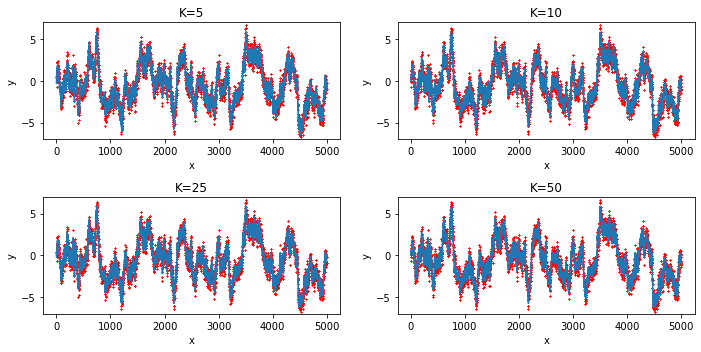

In [10]:
nrows, ncols = (2, 2)
fix, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,5))
x, y = (0, -1)

for idx, k in enumerate(K):
    if ((idx % ncols) == 0) and not (idx == 0):
        x = x + 1
        y = -1    
    y = y + 1
    axs[x][y].plot(all_ens_mu[k])
    axs[x][y].scatter(list(range(len(obs))), obs, s=1.5, c='red', marker='x')
    axs[x][y].set_title('K=' + str(k))
    axs[x][y].set_xlabel('x')
    axs[x][y].set_ylabel('y')
    axs[x][y].set_ylim([-7,7])

plt.tight_layout()
plt.show()

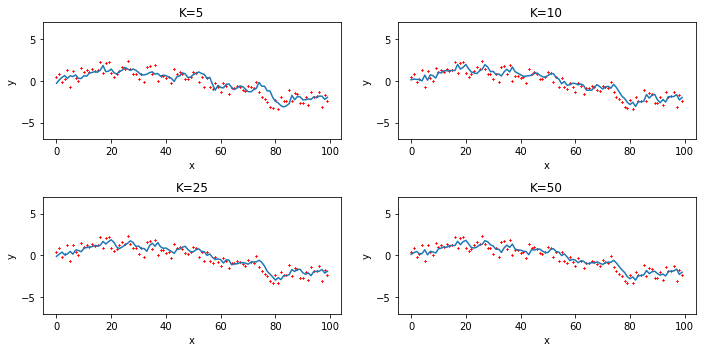

In [11]:
nrows, ncols = (2, 2)
fix, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,5))
x, y = (0, -1)

for idx, k in enumerate(K):
    if ((idx % ncols) == 0) and not (idx == 0):
        x = x + 1
        y = -1    
    y = y + 1
    axs[x][y].plot(all_ens_mu[k][:100])
    axs[x][y].scatter(list(range(len(obs[:100]))), obs[:100], s=1.5, c='red', marker='x')
    axs[x][y].set_title('K=' + str(k))
    axs[x][y].set_xlabel('x')
    axs[x][y].set_ylabel('y')
    axs[x][y].set_ylim([-7,7])

plt.tight_layout()
plt.show()

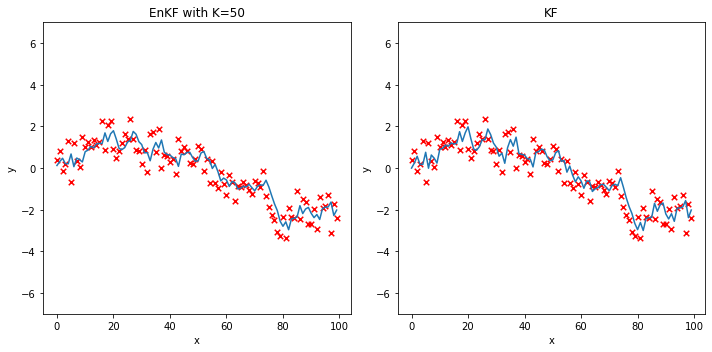

In [12]:
nrows, ncols = (1, 2)
fix, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,5))
x, y = (0, 0)

axs[x].plot(all_ens_mu[50][:100])
axs[x].scatter(list(range(len(obs[:100]))), obs[:100], s=30, c='red', marker='x')
axs[x].set_title('EnKF with K=' + str(50))
axs[x].set_xlabel('x')
axs[x].set_ylabel('y')
axs[x].set_ylim([-7,7])

x = x + 1
axs[x].plot(meansKF[:100])
axs[x].scatter(list(range(len(obs[:100]))), obs[:100], s=30, c='red', marker='x')
axs[x].set_title('KF')
axs[x].set_xlabel('x')
axs[x].set_ylabel('y')
axs[x].set_ylim([-7,7])



plt.tight_layout()
plt.show()


In [13]:
ref = np.loadtxt('reference_signal.txt')
obs = np.loadtxt('data.txt')
#No of observations
n = len(obs)

Z = np.zeros(n)
Z_rnd = lambda: np.random.normal(0, np.sqrt(0.5))
Z_0 = Z_rnd()
Z[0] = Z_0
ens_mu = np.zeros(n+1)

eps = lambda s: np.random.normal(0, np.sqrt(0.3), s)
K = [1000, 10000] #ensemble members

all_ens_mu = pd.DataFrame(columns=K)

#instantiate class for empirical computations
emp_obj = emp_class(np.sqrt(0.5), np.sqrt(0.5), obs, ref)

for k in K:
    #Step 1 - init ensemble members
    ens = np.random.normal(0, np.sqrt(0.5), k)
    ens_mu[0] = np.mean(ens)
    for i in rangeb(n):
        #Step 2 - evolutional equation
        ens = 0.99 * ens + eps(k) 

        #Step 3 - compute empirical mean and empirical variance
        emp_mean = emp_obj.emp_mean(ens)
        emp_var = emp_obj.emp_var(ens)

        #Step 4 - compute Kalman Gain
        kg = emp_obj.kalman_gain(emp_var)
        
        #Step 5 - perturbed observation
        #... Happening in class right now

        #Step 6 - Analysis Step - Kalman update
        ens = emp_obj.kalman_update(ens, kg, obs, i)
        
        ens_mu[i+1] = np.mean(ens)
    all_ens_mu[k] = ens_mu
    emp_obj.print_values(ens_mu, k)

for K=1000: MSE:0.10894223461798781
for K=10000: MSE:0.10850982570732776


For comparison: $MSE_{KF} = 0.113510626882344$

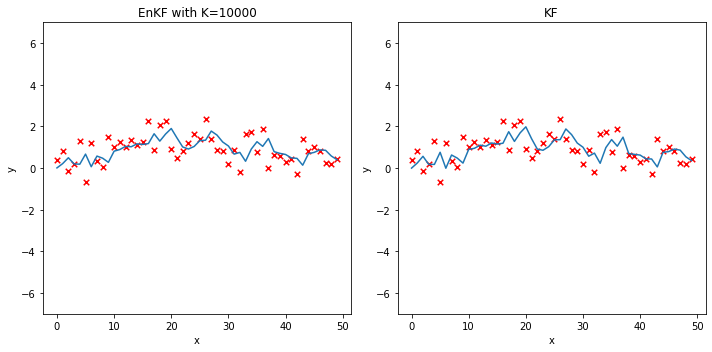

In [18]:
nrows, ncols = (1, 2)
fix, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,5))
x, y = (0, 0)
n = 50

axs[x].plot(all_ens_mu[10000][:n])
axs[x].scatter(list(range(len(obs[:n]))), obs[:n], s=30, c='red', marker='x')
axs[x].set_title('EnKF with K=' + str(10000))
axs[x].set_xlabel('x')
axs[x].set_ylabel('y')
axs[x].set_ylim([-7,7])

x = x + 1
axs[x].plot(meansKF[:n])
axs[x].scatter(list(range(len(obs[:n]))), obs[:n], s=30, c='red', marker='x')
axs[x].set_title('KF')
axs[x].set_xlabel('x')
axs[x].set_ylabel('y')
axs[x].set_ylim([-7,7])



plt.tight_layout()
plt.show()


As the value for K (ensemble members) is increasing, the MSE is decreasing. We can see that the Ensemble Kalman Filter performs better than the Kalman Filter for a larger K (number of ensemble members). However for a small K the Ensemble Kalman Filter actually performs worse, as the MSE is higher than the MSE of the Kalman Filter for small K. 